In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [5]:
innov_dim = 250

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 40
    vol = store['discrete_vol_est'] * 40**2
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,1.018986,0.221712
2003-01-03,0.085707,0.196170
2003-01-06,0.817542,0.115554
2003-01-07,-0.142341,0.208983
2003-01-08,-0.436209,0.162428


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,0.139160,-0.005791
vol,-0.005791,0.047533


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.003718,0.141630
std,0.373042,0.364284
min,-3.298704,0.003107
25%,-0.151435,0.034785
50%,0.020365,0.060872
75%,0.174527,0.126756
max,2.862066,10.629397


In [11]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.003718,0.141630
std,0.373042,0.364284
min,-3.298704,0.003107
25%,-0.151435,0.034785
50%,0.020365,0.060872
75%,0.174527,0.126756
max,2.862066,10.629397


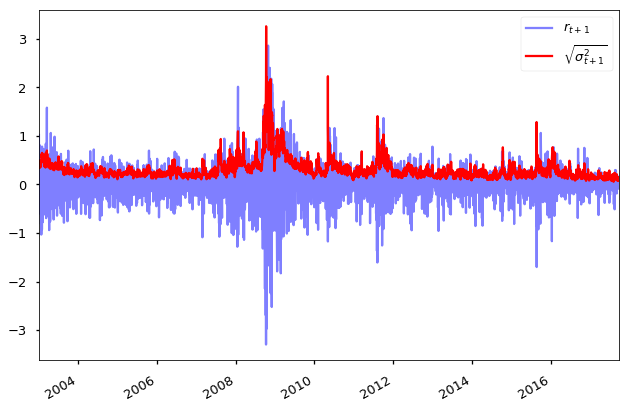

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

(None,)

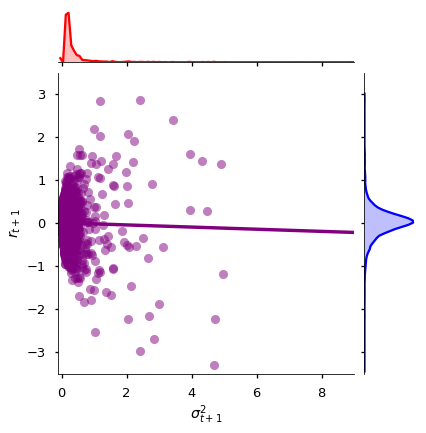

In [13]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data, xlim=[-.1, 9], ylim=[-3.5, 3.5])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True),

In [14]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [15]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol))

In [16]:
estimates

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667}

In [17]:
covariance

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.003869,-0.000035,0.000000,0.000000,0.000000,-0.003624,0.000000
gamma,-0.000035,0.000016,0.000000,0.000000,0.000000,-0.000080,0.000000
log_both,0.000000,0.000000,0.016276,0.014685,-0.026087,0.000000,0.000000
log_scale,0.000000,0.000000,0.014685,0.213271,0.008542,0.000000,0.000000
logit_rho,0.000000,0.000000,-0.026087,0.008542,0.051510,0.000000,0.000000
psi,-0.003624,-0.000080,0.000000,0.000000,0.000000,0.005924,0.000000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000431


In [18]:
vl.compute_strong_id(estimates, covariance)

({'phi': -0.3198925047471951,
  'pi': -0.5135657600538964,
  'theta': 0.23849043088785027},
             phi        pi     theta
 phi    0.001043 -0.025240 -0.002971
 pi    -0.025240  3.898668  0.466181
 theta -0.002971  0.466181  0.112220)

In [19]:
strong_id_results = vl.estimate_params_strong_id(data) 

In [20]:
strong_id_results

({'gamma': 0.041215374512209656,
  'beta': 0.7015382455834713,
  'psi': -0.9685558579808327,
  'zeta': 0.9086856628806302,
  'log_both': -3.413201821157824,
  'log_scale': -2.6713608707688548,
  'logit_rho': 1.032155385706667,
  'phi': -0.3198957593239639,
  'pi': -0.5126748272186379,
  'theta': 0.238554251805499},
                beta     gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.003869 -0.000035  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000035  0.000016  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000  0.016276   0.014685  -0.026087       NaN   
 log_scale  0.000000  0.000000  0.014685   0.213271   0.008542       NaN   
 logit_rho  0.000000  0.000000 -0.026087   0.008542   0.051510       NaN   
 phi             NaN       NaN       NaN        NaN        NaN  0.001043   
 pi              NaN       NaN       NaN        NaN        NaN -0.025240   
 psi       -0.003624 -0.000080  0.000000   0.000000   0.000000       NaN   

In [21]:
omega

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667,
 'phi': -0.29731504194564906,
 'pi': -8.687099478274641,
 'theta': 0.49306643287875435}

In [22]:
pd.Series(omega)

gamma        0.041215
beta         0.701538
psi         -0.968556
zeta         0.908686
log_both    -3.413202
log_scale   -2.671361
logit_rho    1.032155
phi         -0.297315
pi          -8.687099
theta        0.493066
dtype: float64

In [23]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,phi,pi,psi,theta,zeta
beta,0.003869,-0.000035,0.000000,0.000000,0.000000,NaN,NaN,-0.003624,NaN,0.000000
gamma,-0.000035,0.000016,0.000000,0.000000,0.000000,NaN,NaN,-0.000080,NaN,0.000000
log_both,0.000000,0.000000,0.016276,0.014685,-0.026087,NaN,NaN,0.000000,NaN,0.000000
log_scale,0.000000,0.000000,0.014685,0.213271,0.008542,NaN,NaN,0.000000,NaN,0.000000
logit_rho,0.000000,0.000000,-0.026087,0.008542,0.051510,NaN,NaN,0.000000,NaN,0.000000
phi,NaN,NaN,NaN,NaN,NaN,0.001147,-0.019830,NaN,-0.003666,NaN
pi,NaN,NaN,NaN,NaN,NaN,-0.019830,11.064984,NaN,-0.484766,NaN
psi,-0.003624,-0.000080,0.000000,0.000000,0.000000,NaN,NaN,0.005924,NaN,0.000000
theta,NaN,NaN,NaN,NaN,NaN,-0.003666,-0.484766,NaN,0.106418,NaN
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000431


In [24]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.003107
2017-09-14    0.005409
2017-09-22    0.005464
2016-11-25    0.005700
2017-07-24    0.006115
Name: vol, dtype: float64

In [25]:
omega2, omega_cov2 = vl.estimate_params(data)

In [26]:
omega2

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667}

In [27]:
omega

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667,
 'phi': -0.29731504194564906,
 'pi': -8.687099478274641,
 'theta': 0.49306643287875435}

In [32]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=5, pi_dim=5, phi_dim=1, 
                                 pi_min=-16, pi_max=0, phi_min=-.30, phi_max=-.3, theta_min=0, 
                                 theta_max=5, use_tqdm=True)

In [33]:
qlr_stats

,phi,pi,theta,qlr
0,-0.3,-16.0,0.00,inf
1,-0.3,-16.0,2.50,inf
2,-0.3,-16.0,1.25,inf
3,-0.3,-8.0,0.00,6.817839
4,-0.3,-12.0,3.75,762.418514
5,-0.3,-12.0,5.00,799.029765
6,-0.3,-8.0,1.25,29.228177
7,-0.3,-8.0,2.50,208.023425
8,-0.3,-8.0,3.75,370.725315
9,-0.3,-8.0,5.00,473.878726


In [29]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2,  theta_dim=5, pi_dim=5, phi_dim=1, 
                                 pi_min=-16, pi_max=0, phi_min=-.30, phi_max=-.3, theta_min=0, 
                                 theta_max=5, use_tqdm=True, alpha=0.05, innov_dim=innov_dim)

I am here!
I am here!
I am here!
I am here!


I am here!


I am here!
I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


I am here!


In [34]:
qlr_stats.set_index(['phi', 'pi', 'theta'])

qlr
phi  pi    theta            
-0.3 -16.0 0.00          inf
           2.50          inf
           1.25          inf
     -8.0  0.00     6.817839
     -12.0 3.75   762.418514
           5.00   799.029765
     -8.0  1.25    29.228177
           2.50   208.023425
           3.75   370.725315
           5.00   473.878726
     -4.0  0.00    12.437606
           1.25    11.478352
           2.50    57.930476
           3.75   248.611343
           5.00   395.872411
      0.0  0.00     1.874682
           1.25    18.677465
           2.50    90.873267
           3.75   204.056414
           5.00   326.792708
     -12.0 0.00     0.000000
     -16.0 3.75     0.000000
     -12.0 1.25     0.000000
           2.50     0.000000
     -16.0 5.00     0.000000

In [35]:
qlr_stats.count()

phi      25
pi       25
theta    25
qlr      25
dtype: int64

In [36]:
qlr_stats.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
qlr_draws.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
close_enough = np.allclose(qlr_stats[['phi', 'pi', 'theta']], qlr_draws[['phi', 'pi', 'theta']])

if not close_enough:
    raise RuntimeError('The indices are not the same!!!')
    
else:
    qlr_stats[['phi', 'pi', 'theta']] = qlr_draws[['phi', 'pi', 'theta']]
    
    
merged_values = pd.merge(qlr_stats, qlr_draws,left_on=['phi', 'pi', 'theta'], right_on=['phi', 'pi', 'theta'],
                         suffixes=['_draws', '_stats'])

In [37]:
qlr_stats.sort_values(by='qlr').head()

,phi,pi,theta,qlr
21,-0.3,0.0,5.00,0.0
24,-0.3,0.0,3.75,0.0
20,-0.3,0.0,0.00,0.0
22,-0.3,0.0,1.25,0.0
23,-0.3,0.0,2.50,0.0


In [38]:
qlr_draws.sort_values(by='qlr').head()

,phi,pi,theta,qlr
1,-0.3,-16.0,0.00,0.000000
0,-0.3,-16.0,1.25,0.000000
2,-0.3,-16.0,2.50,0.000000
14,-0.3,-4.0,2.50,0.000000
3,-0.3,-8.0,0.00,1.385105


In [39]:
merged_values

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.3,-16.0,1.25,inf,0.000000
1,-0.3,-16.0,2.50,inf,0.000000
2,-0.3,-16.0,0.00,inf,0.000000
3,-0.3,0.0,5.00,0.000000,3.722398
4,-0.3,0.0,3.75,0.000000,4.834275
5,-0.3,0.0,0.00,0.000000,2.754267
6,-0.3,0.0,1.25,0.000000,6.066600
7,-0.3,0.0,2.50,0.000000,5.159946
8,-0.3,-12.0,1.25,762.418514,2.906237
9,-0.3,-16.0,5.00,799.029765,5.251873


In [40]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [41]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [42]:
accepted_vals

,phi,pi,theta
3,-0.3,0.0,5.00
4,-0.3,0.0,3.75
5,-0.3,0.0,0.00
6,-0.3,0.0,1.25
7,-0.3,0.0,2.50
20,-0.3,-4.0,1.25


In [43]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [44]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [45]:
accepted_vals

,phi,pi,theta
3,-0.3,0.0,5.00
4,-0.3,0.0,3.75
5,-0.3,0.0,0.00
6,-0.3,0.0,1.25
7,-0.3,0.0,2.50
20,-0.3,-4.0,1.25


In [46]:
omega

{'gamma': 0.041215374512209656,
 'beta': 0.7015382455834713,
 'psi': -0.9685558579808327,
 'zeta': 0.9086856628806302,
 'log_both': -3.413201821157824,
 'log_scale': -2.6713608707688548,
 'logit_rho': 1.032155385706667,
 'phi': -0.29731504194564906,
 'pi': -8.687099478274641,
 'theta': 0.49306643287875435}

In [47]:
accepted_vals

,phi,pi,theta
3,-0.3,0.0,5.00
4,-0.3,0.0,3.75
5,-0.3,0.0,0.00
6,-0.3,0.0,1.25
7,-0.3,0.0,2.50
20,-0.3,-4.0,1.25


In [51]:
accepted_vals

,phi,pi,theta
3,-0.3,0.0,5.00
4,-0.3,0.0,3.75
5,-0.3,0.0,0.00
6,-0.3,0.0,1.25
7,-0.3,0.0,2.50
20,-0.3,-4.0,1.25


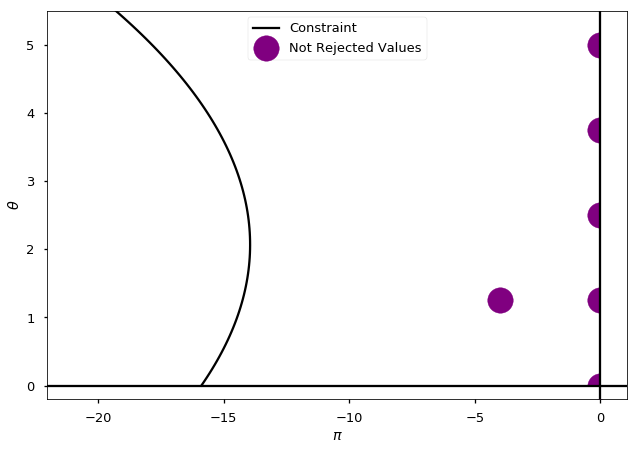

In [93]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=650, label='Not Rejected Values',
           color='purple')

max_y = accepted_vals.theta.max()
min_x = accepted_vals.pi.min()

yvals = np.linspace(0,max_y+1,100)
xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=0, ymax=1, color='black')
ax3.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((min_x-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect1)
ax3.add_patch(white_rect2)
ax3.set_ylim([-.2, max_y+.5])
# ax3.set_xlim([min_x - .2, .2])
ax3.set_ylabel(r'$\theta$')
ax3.set_xlabel(r'$\pi$')
ax3.legend(loc='upper center')

fig3.savefig('../doc/figures/confidence_region_2_flattened.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [49]:
accepted_vals.min()

phi     -0.3
pi      -4.0
theta    0.0
dtype: float64

In [50]:
accepted_vals.max()

phi     -0.3
pi       0.0
theta    5.0
dtype: float64